In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [5]:
df = pd.read_csv(r"C:\Users\Lenovo\Downloads\EDA HEART\heart_disease_dataset.csv")
print("Dataset shape:", df.shape)

Dataset shape: (1000, 16)


In [6]:
X = df.drop('Heart Disease', axis=1)
y = df['Heart Disease']

In [9]:
X_encoded = pd.get_dummies(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)


In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

In [13]:
print("\n=== Initial Model Evaluation ===")
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f"\n{name} Report:")
    print(classification_report(y_test, y_pred))


=== Initial Model Evaluation ===

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       122
           1       0.85      0.78      0.81        78

    accuracy                           0.86       200
   macro avg       0.86      0.85      0.85       200
weighted avg       0.86      0.86      0.86       200


Random Forest Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       122
           1       1.00      0.97      0.99        78

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200


SVM Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.91       122
           1       0.90      0.78      0.84        78

    accuracy                           0.88       200
   macro avg       0.88      

In [14]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs']
}
grid_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_lr.fit(X_train_scaled, y_train)
best_lr = grid_lr.best_estimator_

In [15]:
param_dist_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}
random_rf = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist_rf,
                               n_iter=10, cv=5, scoring='f1', n_jobs=-1, random_state=42)
random_rf.fit(X_train_scaled, y_train)
best_rf = random_rf.best_estimator_

In [16]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
grid_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='f1', n_jobs=-1)
grid_svm.fit(X_train_scaled, y_train)
best_svm = grid_svm.best_estimator_

In [17]:
def evaluate_model(name, model):
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"\n{name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    return [name, acc, prec, rec, f1]

results = []
results.append(evaluate_model("Logistic Regression (Tuned)", best_lr))
results.append(evaluate_model("Random Forest (Tuned)", best_rf))
results.append(evaluate_model("SVM (Tuned)", best_svm))


Logistic Regression (Tuned):
Accuracy: 0.8650
Precision: 0.8493
Recall: 0.7949
F1 Score: 0.8212

Random Forest (Tuned):
Accuracy: 0.9950
Precision: 1.0000
Recall: 0.9872
F1 Score: 0.9935

SVM (Tuned):
Accuracy: 0.8800
Precision: 0.8553
Recall: 0.8333
F1 Score: 0.8442


In [18]:
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])
print("\n=== Final Model Comparison ===")
print(results_df.sort_values(by="F1 Score", ascending=False))


=== Final Model Comparison ===
                         Model  Accuracy  Precision    Recall  F1 Score
1        Random Forest (Tuned)     0.995   1.000000  0.987179  0.993548
2                  SVM (Tuned)     0.880   0.855263  0.833333  0.844156
0  Logistic Regression (Tuned)     0.865   0.849315  0.794872  0.821192


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns


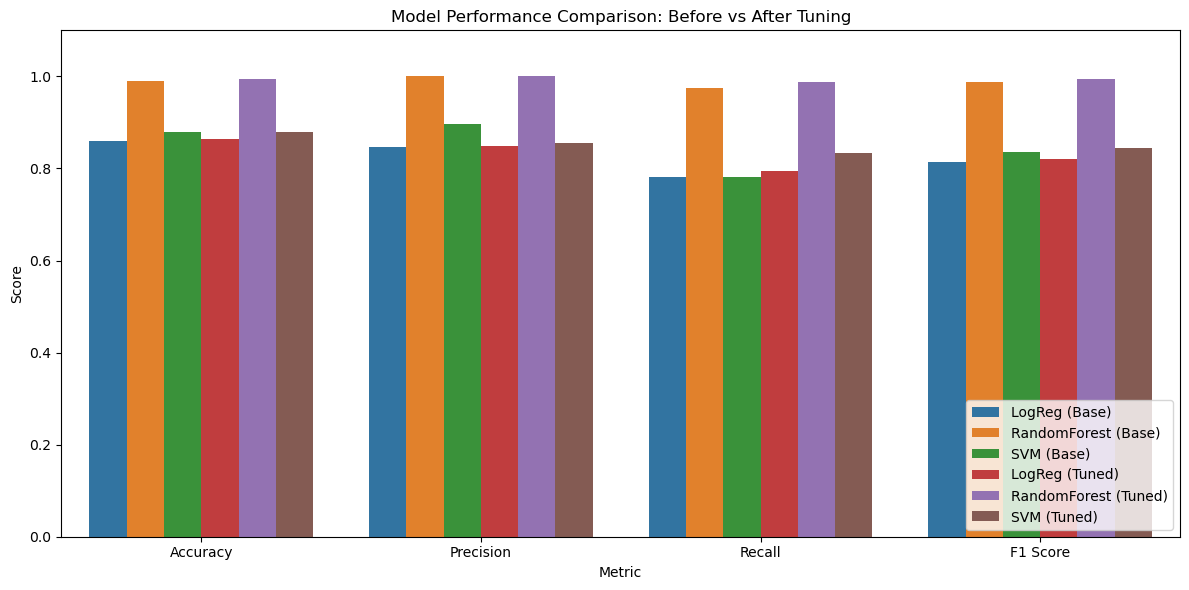

In [20]:
def get_metrics(model, name):
    y_pred = model.predict(X_test_scaled)
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred)
    }

base_results = [
    get_metrics(models["Logistic Regression"], "LogReg (Base)"),
    get_metrics(models["Random Forest"], "RandomForest (Base)"),
    get_metrics(models["SVM"], "SVM (Base)")
]

tuned_results = [
    get_metrics(best_lr, "LogReg (Tuned)"),
    get_metrics(best_rf, "RandomForest (Tuned)"),
    get_metrics(best_svm, "SVM (Tuned)")
]

combined_df = pd.DataFrame(base_results + tuned_results)

df_melted = pd.melt(combined_df, id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x="Metric", y="Score", hue="Model")
plt.title("Model Performance Comparison: Before vs After Tuning")
plt.ylim(0, 1.1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()